# Transformer from scratch

This notebook builds a basic **Encoder-Decoder** variant of the Transformer architecture from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in TensorFlow.

It serves to understand how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task : **translating sentences from English to French**.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

**Steps :**
1. [Preparing the data](#Preparing-the-data)
2. [Building the Transformer](#Building-the-Transformer)
3. [Training the Transformer](#Training-the-Transformer)
4. [Testing the Transformer](#Testing-the-Transformer)
    
*[Credits and stuff](#Credits-and-stuff)*

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import numpy as np

/tmp/ipykernel_131541/4184736172.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-01-23 23:10:26.724229: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-23 23:10:26.760526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 23:1

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

GPU is AVAILABLE


2024-01-23 23:10:32.370613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 23:10:32.513014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-23 23:10:32.513412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [3]:
# get the file path
file_path = '../data/en-pl.csv'

# read the data
df = pd.read_csv(file_path).truncate(after=100_000)
df['source'] = df['pl']

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df['target'] = df['en'].apply(lambda x: '[start] ' + x + ' [end]')

df = df.drop(['pl', 'en'], axis=1)

# display a few random samples
df.sample(5)

,source,target
14953,"Etykieta zawiera chińskie znaki ""China Organic...",[start] The label contains Chinese characters ...
26233,"Château des Charmes, Niagara- on-the- Lake, On...","[start] Château des Charmes, Niagara-on-the-La..."
93011,• Świadomy udział lub wkład w działalność grup...,[start] • Knowingly participating in or contri...
76172,Canada Mortgage and Housing Corporation (CMHC)...,[start] Canada Mortgage and Housing Corporatio...
41864,• Regionalny profil rolno-spożywczy - Przegląd...,[start] • Agri-Food Regional Profile - Statist...


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Shuffling the data and splitting it into train, validation, and test sets</b></p>
</div>

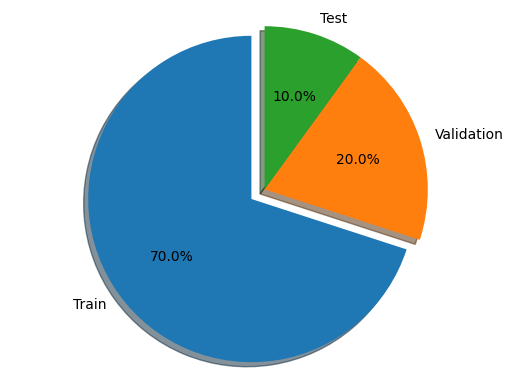

In [4]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Standardizing, tokenizing and indexing the data</b></p>
</div>

First, we need to parse our raw text data and vectorize it.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sentence using the **sequence_length** parameter.

Each sentence will be standardized, tokenized by word, and then indexed by token.

This will result in a batch of vectors of tokens, stored in a **2D** matrix of shape [(batch_size, **sequence_length**)].

In [7]:
max_tokens = 12000
sequence_length = 15

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values

In [8]:
source_vectorization.adapt(train_source_texts)

In [9]:
target_vectorization.adapt(train_target_texts)

In [10]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): Office of the Commissioner for Federal Judicial Affairs 3.
Target texts (one random sample): [start] Office of the Commissioner for Federal Judicial Affairs  3. [end]
Source vectors (one random sample): tf.Tensor(
[1058   44   73 3948  161 1415 2971  663  109    0    0    0    0    0
    0], shape=(15,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   3  263    5    2  334   10  132 1042 5298  191    4    0    0    0
    0    0], shape=(16,), dtype=int64)
Source decoded texts (one random sample): office of the commissioner for federal judicial affairs 3       
Target decoded texts (one random sample): [start] office of the commissioner for federal judicial affairs  3 [end]      


In [12]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (70000, 15)
Target vectors (shape): (70000, 16)


# Building the Transformer

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Positional Embedding</b></p>
</div>

In order for our Transformer to be aware of the word order in each sentence, we must add some positional information to the data. **Words must become position-aware.**

First, each token in our vectors will be embedded in a low-dimensional vector (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Secondly, position information (info on where each word stands in the sentence) will be created and added to the embeddings.

This will result in a batch of vectors of positional embeddings, stored in a **3D** matrix of shape [(batch_size, sequence_length, **embedding_size**)].

In [13]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [ ]:
# display a random sample before and after embbeding just to test our class

embed_dim = 64

train_source_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="source_embedding",
) (train_source_vectors)

train_target_embedded = PositionalEmbedding(
    sequence_length=sequence_length,
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="target_embedding",
) (train_source_vectors)

random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

In [19]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (70000, 15, 64)
Target embedded vectors (shape): (70000, 15, 64)


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Attention mechanism</b></p>
</div>

The goal here is to make each of our words (positional embeddings at this point) aware of the other words surrounding them. **Words must become context-aware.**

The implementation of the Attention mechanism involves the following 3 steps : 

- Causal Masking
- Scaled Dot-Product Attention
- Multi-Head Attention

In practice, we could just use **tf.keras.layers.MultiHeadAttention** instead of building it from scratch, but let's do it anyway! 😒

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Causal Masking</b></p>
</div>


Since our words will now be context-aware (aware of words before **and** after them in the sentence), we need a way to mask those *after-words* when needed be (i.e. during training).

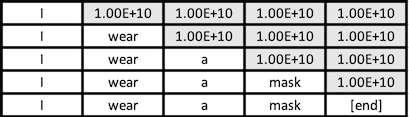

In [20]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [21]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 1.10010505e-01 -1.00000000e+10 -1.00000000e+10 -1.00000000e+10
    -1.00000000e+10]
   [ 1.37032866e-01  5.97499609e-02 -1.00000000e+10 -1.00000000e+10
    -1.00000000e+10]
   [ 5.89616060e-01  2.53011703e-01  5.05310416e-01 -1.00000000e+10
    -1.00000000e+10]
   [ 3.54104280e-01  7.40357876e-01  5.82142830e-01  9.28657174e-01
    -1.00000000e+10]
   [ 4.83971119e-01  7.50534177e-01  1.58786178e-01  3.03326011e-01
     7.28219748e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Scaled Dot-Product Attention</b></p>
</div>

This function is what makes our words context-aware.

We want to compare each word with every other words around them and take note of how *related* they are. Technically, this process can be described as "mapping a query and a set of key-value pairs to an output". It can be summarized as follows :
- We take a **Q**uery of elements.
- For each element in the **Q**uery, we score how much that element is related to every **K**ey (This is done using a compatibility function : MatMul). If needed be, Causal Masking will be applied here.
- Then, we use these relationship scores to weight a sum of **V**alues, which will be our new context-aware representations.

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-19.png" width="120">](https://arxiv.org/abs/1706.03762)

In [22]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [23]:
# display the shape of our attention output just to test the function
input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (70000, 1, 15, 64)


<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Multi-Head Attention</b></p>
</div>

Multi-head attention was introduced in [Attention is all you need](https://arxiv.org/abs/1706.03762) and is wayyy to technical for me to try and explain here. But basically, it allows for multiple Scaled Dot-Production Attention functions to be run in parallel. 😅
    
[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-20.png" width="200">](https://arxiv.org/abs/1706.03762)

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = tf.keras.layers.Dense(embed_dim)
        self.k_linear = tf.keras.layers.Dense(embed_dim)
        self.v_linear = tf.keras.layers.Dense(embed_dim)
        self.concat_linear = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Encoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_encoder-zoom.png" width="400">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Encoder is to process the source sentence. Here, no Causal Masking is needed : information is allowed to flow in both directions (words can be aware of words before **and** after them in the sentence).

The Encoder's a pretty generic module that ingests a sentence and learns to turn it into a more useful representation. It can also be used by itself (without the Decoder) for Natural Language Understanding (NLU) tasks like Classification or Named Entity Recognition (NER).

In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the **Source Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [27]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Decoder</b></p>
</div>

[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_decoder-zoom.png" width="500">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)

The role of the Decoder is to look at the target sentence so far and predict the next word in that sentence.

Contrary to the Encoder, the Decoder is made of two Attention layers. The first Attention layer does a similar job as the Encoder's sole Attention layer, with the important distinction that here, Causal Masking is enabled because, to correctly train our Transformer to predict the next word based on the current word and the previous words in the sentence, we need to mask the *after-words*. Meanwhile, The second Attention layer is much more straight-forward and basically just acts as a bridge that connects the Encoder to the Decoder.

In the Decoder's first Attention layer, the Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the **Target Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue. Like mentionned above, Causal Masking is enabled in this layer.

In the Decoder's second Attention layer, the Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the **outputs of the Encoder** are being passed to the **K**ey and **V**alue parameters, with the **outputs of the Decoder's Masked Multi-Head Self-Attention layer** being passed to the **Q**uery parameter.


In [28]:
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-7)
        self.layer_norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-7)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

In [ ]:
class TransformerDecoder(tf.keras.layers.Layer):
    

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Putting it all together</b></p>
</div>

[<img src="https://ar5iv.labs.arxiv.org/html/1706.03762/assets/Figures/ModalNet-21.png" width="300">](https://arxiv.org/abs/1706.03762)

We  turn our data into a *tf.data pipeline* that returns a tuple (Inputs, Outputs) where Inputs is a dict with two keys : **encoder_inputs** (the source sentence) and **decoder_inputs** (the target sentence), and Outputs is a single key : **decoder_outputs** (the target sentence "shifted right").

During training, the fact that our Outputs are offset by one step ahead ("shifted right"), combined with the Causal Masking of the Decoder (Masked Multi-Head Attention layer), ensures that the
predictions for position *i* can depend only on the known outputs at positions less than *i* (no *after-words* visible).

During inference, we'll generate one target word at a time and then feed it back into the Decoder so that it can predict the next word. And so on.

In [30]:
batch_size = 32

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [31]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (32, 15)
Decoder Inputs: (32, 15)
Decoder Outputs: (32, 15)


2024-01-23 23:45:55.514836: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/main/images/chapter03_transformer-encoder-decoder.png" width="600">](https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb)


In [ ]:
class abc(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, num_layers):
        super(bac, self).__init__()

        self.transformer_encoders = [TransformerEncoder(embed_dim, dense_dim, num_heads) for _ in range(num_layers)]

    def call(self, x):
        for encoder in self.transformer_encoders:
            x = encoder(x)

        return x

In [33]:
embed_dim = 64 # dimension of the embedding space
dense_dim = 4*embed_dim # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 4

# the transformer body
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder2(embed_dim, dense_dim, num_heads, 2)(x)
decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Training the Transformer

In [34]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 1
checkpoint_filepath = '/tmp/checkpoint/'
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

# transformer.load_weights(checkpoint_filepath)

2024-01-23 23:53:34.804309: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f17b000df40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 23:53:34.804350: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-01-23 23:53:34.810268: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-23 23:53:35.150187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706050415.205284  132548 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  55/2188 [..............................] - ETA: 4:10 - loss: 8.0243 - accuracy: 0.1199

KeyboardInterrupt: 

# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [1]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 10

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

NameError: name 'target_vectorization' is not defined

# Credits and stuff

- https://arxiv.org/abs/1706.03762

- https://www.tensorflow.org/text/tutorials/transformer

- https://github.com/openai/gpt-2/blob/master/src/model.py

- https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

- https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part03_transformer.ipynb

    - https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter11_part04_sequence-to-sequence-learning.ipynb

- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/ch03.html

    - https://github.com/nlp-with-transformers/notebooks/blob/main/03_transformer-anatomy.ipynb